In [1]:
import numpy
import netCDF4
import matplotlib
import matplotlib.pyplot as mp
import datetime
import matplotlib.colors
import scipy.stats
import itertools
import string

import matplotlib.ticker
import cartopy.mpl.gridliner #import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import mpl_toolkits
import cartopy

DEGREE_SIGN = u'\u00B0'
mp.rcParams.update({'mathtext.default': 'regular'})

% matplotlib inline

In [2]:
run_info = 'FMAASO'
skip_time=0

# GEO EM FILE

In [3]:
geo_em_ncfile = netCDF4.Dataset('/Users/baird/Dropbox/_data_WRF/geo_em.d01_amazon_50km.nc')
HGT_M = geo_em_ncfile.variables['HGT_M'][0,:,:]

# time, LAT, LON ncfiles

In [4]:
xlat_ncfile_name = '/Users/baird/Dropbox/_data_WRF/CHEYENNE/FMAASO/1000/concat_nc_files/wrfout_d01_1979-01-01_00:00:00_XLAT.nc'
xlong_ncfile_name = '/Users/baird/Dropbox/_data_WRF/CHEYENNE/FMAASO/1000/concat_nc_files/wrfout_d01_1979-01-01_00:00:00_XLONG.nc'
landmask_ncfile_name = '/Users/baird/Dropbox/_data_WRF/CHEYENNE/FMAASO/1000/concat_nc_files/wrfout_d01_1979-01-01_00:00:00_LANDMASK.nc'
times_ncfile_name = '/Users/baird/Dropbox/_data_WRF/CHEYENNE/FMAASO/1000/concat_nc_files/wrfout_d01_1979-01-01_00:00:00_1979-01-11_00:00:00_Times_ens_mean.nc'

# import FMAASO 400 data

In [5]:
data_dir = '/Users/baird/Dropbox/_data_WRF/CHEYENNE/FMAASO/400/concat_nc_files/'
filename_prefix = 'wrfout_d01_1979-01-01_00:00:00_1979-01-11_00:00:00_'
filename_suffix = '_ens_mean.nc'

time_ncfile = netCDF4.Dataset(times_ncfile_name)
xlat_ncfile = netCDF4.Dataset(xlat_ncfile_name)
xlong_ncfile = netCDF4.Dataset(xlong_ncfile_name)
landmask_ncfile = netCDF4.Dataset(landmask_ncfile_name)

qvapor_ncfile = netCDF4.Dataset(data_dir + filename_prefix + 'QVAPOR' + '_ens_mean_vinterp_zcoords.nc')

pblh_ncfile = netCDF4.Dataset(data_dir + filename_prefix + 'PBLH' + filename_suffix)
# qvapor_ncfile = netCDF4.Dataset(data_dir + filename_prefix + 'QVAPOR' + '_ens_mean_vinterp.nc')
# u_ncfile = netCDF4.Dataset(data_dir + filename_prefix + 'U' + '_ens_mean_vinterp.nc')
# v_ncfile = netCDF4.Dataset(data_dir + filename_prefix + 'V' + '_ens_mean_vinterp.nc')
# w_ncfile = netCDF4.Dataset(data_dir + filename_prefix + 'W' + '_ens_mean_vinterp.nc')

In [6]:
time_var = time_ncfile.variables['Times']
time = time_ncfile.variables['Times'][:]
xlat = xlat_ncfile.variables['XLAT'][0,:,:]
xlong = xlong_ncfile.variables['XLONG'][0,:,:]
landmask = landmask_ncfile.variables['LANDMASK'][0,:,:]

z = qvapor_ncfile.variables['z'][:]
qvapor_400 = qvapor_ncfile.variables['QVAPOR'][:]

pblh_400 = pblh_ncfile.variables['PBLH'][:]

# import FMAASO 1000 data

In [7]:
data_dir = '/Users/baird/Dropbox/_data_WRF/CHEYENNE/FMAASO/1000/concat_nc_files/'
filename_prefix = 'wrfout_d01_1979-01-01_00:00:00_1979-01-11_00:00:00_'
filename_suffix = '_ens_mean.nc'

time_ncfile = netCDF4.Dataset(times_ncfile_name)
xlat_ncfile = netCDF4.Dataset(xlat_ncfile_name)
xlong_ncfile = netCDF4.Dataset(xlong_ncfile_name)
landmask_ncfile = netCDF4.Dataset(landmask_ncfile_name)

qvapor_ncfile = netCDF4.Dataset(data_dir + filename_prefix + 'QVAPOR' + '_ens_mean_vinterp_zcoords.nc')

pblh_ncfile = netCDF4.Dataset(data_dir + filename_prefix + 'PBLH' + filename_suffix)

In [8]:
time_var_1000 = time_ncfile.variables['Times']
time_1000 = time_ncfile.variables['Times'][:]
xlat = xlat_ncfile.variables['XLAT'][0,:,:]
xlong = xlong_ncfile.variables['XLONG'][0,:,:]
landmask = landmask_ncfile.variables['LANDMASK'][0,:,:]

qvapor_1000 = qvapor_ncfile.variables['QVAPOR'][:]

pblh_1000 = pblh_ncfile.variables['PBLH'][:]

# get time stamps

In [9]:
time_datetimes = numpy.zeros(time.shape[0], dtype=object)
for t in range(time.shape[0]):
    time_string = ''.join([i.decode('utf-8') for i in time[t,:]])
    year,month,day = time_string.split('_')[0].split('-')
    hour,minute,second = time_string.split('_')[1].split(':')
    time_datetimes[t] = datetime.datetime(int(year),int(month),int(day),int(hour),int(second),int(minute))

In [10]:
skip_time = 24
n_intervals = 8
hour_strings = ['00','03','06','09','12','15','18','21']

times_00 = [t.hour in [23,0,1] for t in time_datetimes[skip_time:]]
times_03 = [t.hour in [2,3,4] for t in time_datetimes[skip_time:]]
times_06 = [t.hour in [5,6,7] for t in time_datetimes[skip_time:]]
times_09 = [t.hour in [8,9,10] for t in time_datetimes[skip_time:]]
times_12 = [t.hour in [11,12,13] for t in time_datetimes[skip_time:]]
times_15 = [t.hour in [14,15,16] for t in time_datetimes[skip_time:]]
times_18 = [t.hour in [17,18,19] for t in time_datetimes[skip_time:]]
times_21 = [t.hour in [20,21,22] for t in time_datetimes[skip_time:]]

# QVAPOR differences

In [11]:
qvapor_diffs = qvapor_1000-qvapor_400

In [12]:
qvapor_diffs.shape

(241, 26, 179, 289)

# PBLH differences

In [13]:
pblh_diffs = pblh_1000 - pblh_400

In [14]:
pblh_diffs.shape

(241, 179, 289)

# QVAPOR lat means

In [15]:
lat_hi = 10.
lat_lo = -10.

In [16]:
qvapor_diffs_landmask = numpy.copy(qvapor_diffs)
qvapor_diffs_landmask[:,:,landmask==1]=numpy.nan
qvapor_diffs_landmask[qvapor_diffs_landmask==9.96921e36]=numpy.nan

In [17]:
qvapor_400_landmask = numpy.copy(qvapor_400)
qvapor_400_landmask[:,:,landmask==1]=numpy.nan
qvapor_400_landmask[qvapor_400_landmask==9.96921e36]=numpy.nan

In [18]:
# subset between lat_hi and lat_lo
lat_indices = (xlat<=lat_hi)&(xlat>=lat_lo)
qvapor_diffs_lat_subset = qvapor_diffs[:,:,lat_indices[:,0],:]

In [19]:
qvapor_400_lat_subset = qvapor_400[:,:,lat_indices[:,0],:]

In [20]:
qvapor_diffs_lat_mean = numpy.nanmean(qvapor_diffs_lat_subset, axis=2)

In [21]:
qvapor_400_lat_mean = numpy.nanmean(qvapor_400_lat_subset, axis=2)

# PBLH lat means

In [22]:
pblh_diffs_landmask = numpy.copy(pblh_diffs)
pblh_diffs_landmask[:,landmask==0]=numpy.nan
pblh_diffs_landmask[pblh_diffs_landmask==9.96921e36]=numpy.nan

In [23]:
pblh_400_landmask = numpy.copy(pblh_400)
pblh_400_landmask[:,landmask==0]=numpy.nan
#pblh_400_landmask[pblh_400_landmask==9.96921e36]=numpy.nan

In [24]:
pblh_1000_landmask = numpy.copy(pblh_1000)
pblh_1000_landmask[:,landmask==0]=numpy.nan
#pblh_1000_landmask[pblh_1000_landmask==9.96921e36]=numpy.nan

In [25]:
pblh_diffs_lat_subset = pblh_diffs_landmask[:,lat_indices[:,0],:]
pblh_400_lat_subset = pblh_400_landmask[:,lat_indices[:,0],:]
pblh_1000_lat_subset = pblh_1000_landmask[:,lat_indices[:,0],:]

In [26]:
pblh_diffs_lat_mean = numpy.nanmean(pblh_diffs_lat_subset, axis=1)
pblh_400_lat_mean = numpy.nanmean(pblh_400_lat_subset, axis=1)
pblh_1000_lat_mean = numpy.nanmean(pblh_1000_lat_subset, axis=1)

/Users/baird/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/Users/baird/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/Users/baird/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


# 3 hourly means of PBLH and QVAPOR lat means

In [27]:
qvapor_400_t00mean = numpy.mean(qvapor_400_lat_mean[skip_time:,:,:][times_00,:,:], axis=0)
qvapor_400_t03mean = numpy.mean(qvapor_400_lat_mean[skip_time:,:,:][times_03,:,:], axis=0)
qvapor_400_t06mean = numpy.mean(qvapor_400_lat_mean[skip_time:,:,:][times_06,:,:], axis=0)
qvapor_400_t09mean = numpy.mean(qvapor_400_lat_mean[skip_time:,:,:][times_09,:,:], axis=0)
qvapor_400_t12mean = numpy.mean(qvapor_400_lat_mean[skip_time:,:,:][times_12,:,:], axis=0)
qvapor_400_t15mean = numpy.mean(qvapor_400_lat_mean[skip_time:,:,:][times_15,:,:], axis=0)
qvapor_400_t18mean = numpy.mean(qvapor_400_lat_mean[skip_time:,:,:][times_18,:,:], axis=0)
qvapor_400_t21mean = numpy.mean(qvapor_400_lat_mean[skip_time:,:,:][times_21,:,:], axis=0)

qvapor_400_array = numpy.array([qvapor_400_t00mean, qvapor_400_t03mean, qvapor_400_t06mean, qvapor_400_t09mean, qvapor_400_t12mean, qvapor_400_t15mean, qvapor_400_t18mean, qvapor_400_t21mean])


In [28]:
# calculate 3 hourly means for 400
qvapor_diffs_t00mean = numpy.mean(qvapor_diffs_lat_mean[skip_time:,:,:][times_00,:,:], axis=0)
qvapor_diffs_t03mean = numpy.mean(qvapor_diffs_lat_mean[skip_time:,:,:][times_03,:,:], axis=0)
qvapor_diffs_t06mean = numpy.mean(qvapor_diffs_lat_mean[skip_time:,:,:][times_06,:,:], axis=0)
qvapor_diffs_t09mean = numpy.mean(qvapor_diffs_lat_mean[skip_time:,:,:][times_09,:,:], axis=0)
qvapor_diffs_t12mean = numpy.mean(qvapor_diffs_lat_mean[skip_time:,:,:][times_12,:,:], axis=0)
qvapor_diffs_t15mean = numpy.mean(qvapor_diffs_lat_mean[skip_time:,:,:][times_15,:,:], axis=0)
qvapor_diffs_t18mean = numpy.mean(qvapor_diffs_lat_mean[skip_time:,:,:][times_18,:,:], axis=0)
qvapor_diffs_t21mean = numpy.mean(qvapor_diffs_lat_mean[skip_time:,:,:][times_21,:,:], axis=0)

qvapor_diffs_array = numpy.array([qvapor_diffs_t00mean, qvapor_diffs_t03mean, qvapor_diffs_t06mean, qvapor_diffs_t09mean, qvapor_diffs_t12mean, qvapor_diffs_t15mean, qvapor_diffs_t18mean, qvapor_diffs_t21mean])

# monthly mean
#qvapor_diffs_time_mean = numpy.mean(qvapor_1000[skip_time:,:,:] - qvapor_diffs[skip_time:,:,:], axis=0)
#qvapor_diffs_time_mean_landmask = numpy.copy(qvapor_diffs_time_mean)
#qvapor_diffs_time_mean_landmask[landmask==0] = numpy.nan

In [29]:
# calculate 3 hourly means for 400
pblh_400_t00mean = numpy.mean(pblh_400_lat_mean[skip_time:][times_00,:], axis=0)
pblh_400_t03mean = numpy.mean(pblh_400_lat_mean[skip_time:][times_03,:], axis=0)
pblh_400_t06mean = numpy.mean(pblh_400_lat_mean[skip_time:][times_06,:], axis=0)
pblh_400_t09mean = numpy.mean(pblh_400_lat_mean[skip_time:][times_09,:], axis=0)
pblh_400_t12mean = numpy.mean(pblh_400_lat_mean[skip_time:][times_12,:], axis=0)
pblh_400_t15mean = numpy.mean(pblh_400_lat_mean[skip_time:][times_15,:], axis=0)
pblh_400_t18mean = numpy.mean(pblh_400_lat_mean[skip_time:][times_18,:], axis=0)
pblh_400_t21mean = numpy.mean(pblh_400_lat_mean[skip_time:][times_21,:], axis=0)

pblh_1000_t00mean = numpy.mean(pblh_1000_lat_mean[skip_time:][times_00,:], axis=0)
pblh_1000_t03mean = numpy.mean(pblh_1000_lat_mean[skip_time:][times_03,:], axis=0)
pblh_1000_t06mean = numpy.mean(pblh_1000_lat_mean[skip_time:][times_06,:], axis=0)
pblh_1000_t09mean = numpy.mean(pblh_1000_lat_mean[skip_time:][times_09,:], axis=0)
pblh_1000_t12mean = numpy.mean(pblh_1000_lat_mean[skip_time:][times_12,:], axis=0)
pblh_1000_t15mean = numpy.mean(pblh_1000_lat_mean[skip_time:][times_15,:], axis=0)
pblh_1000_t18mean = numpy.mean(pblh_1000_lat_mean[skip_time:][times_18,:], axis=0)
pblh_1000_t21mean = numpy.mean(pblh_1000_lat_mean[skip_time:][times_21,:], axis=0)

pblh_400_array = numpy.array([pblh_400_t00mean, pblh_400_t03mean, pblh_400_t06mean, pblh_400_t09mean, pblh_400_t12mean, pblh_400_t15mean, pblh_400_t18mean, pblh_400_t21mean])
pblh_1000_array = numpy.array([pblh_1000_t00mean, pblh_1000_t03mean, pblh_1000_t06mean, pblh_1000_t09mean, pblh_1000_t12mean, pblh_1000_t15mean, pblh_1000_t18mean, pblh_1000_t21mean])

# monthly mean
#pblh_diffs_time_mean = numpy.mean(pblh_1000[skip_time:,:,:] - pblh_400[skip_time:,:,:], axis=0)
#pblh_diffs_time_mean_landmask = numpy.copy(pblh_diffs_time_mean)
#pblh_diffs_time_mean_landmask[landmask==0] = numpy.nan

# 3 hourly diffs of PBLH (2d latlon data)

In [30]:
# calculate 3 hourly means for 400
pblh_diffs_t00mean = numpy.mean(pblh_diffs_landmask[skip_time:,:,:][times_00,:,:], axis=0)
pblh_diffs_t03mean = numpy.mean(pblh_diffs_landmask[skip_time:,:,:][times_03,:,:], axis=0)
pblh_diffs_t06mean = numpy.mean(pblh_diffs_landmask[skip_time:,:,:][times_06,:,:], axis=0)
pblh_diffs_t09mean = numpy.mean(pblh_diffs_landmask[skip_time:,:,:][times_09,:,:], axis=0)
pblh_diffs_t12mean = numpy.mean(pblh_diffs_landmask[skip_time:,:,:][times_12,:,:], axis=0)
pblh_diffs_t15mean = numpy.mean(pblh_diffs_landmask[skip_time:,:,:][times_15,:,:], axis=0)
pblh_diffs_t18mean = numpy.mean(pblh_diffs_landmask[skip_time:,:,:][times_18,:,:], axis=0)
pblh_diffs_t21mean = numpy.mean(pblh_diffs_landmask[skip_time:,:,:][times_21,:,:], axis=0)

pblh_diffs_2d_array = numpy.array([pblh_diffs_t00mean, pblh_diffs_t03mean, pblh_diffs_t06mean, pblh_diffs_t09mean, pblh_diffs_t12mean, pblh_diffs_t15mean, pblh_diffs_t18mean, pblh_diffs_t21mean])

# monthly mean
#pblh_diffs_time_mean = numpy.mean(pblh_1000[skip_time:,:,:] - pblh_diffs[skip_time:,:,:], axis=0)
#pblh_diffs_time_mean_landmask = numpy.copy(pblh_diffs_time_mean)
#pblh_diffs_time_mean_landmask[landmask==0] = numpy.nan

In [38]:
# calculate 3 hourly means for 400
pblh_400_t00mean = numpy.mean(pblh_400_landmask[skip_time:,:,:][times_00,:,:], axis=0)
pblh_400_t03mean = numpy.mean(pblh_400_landmask[skip_time:,:,:][times_03,:,:], axis=0)
pblh_400_t06mean = numpy.mean(pblh_400_landmask[skip_time:,:,:][times_06,:,:], axis=0)
pblh_400_t09mean = numpy.mean(pblh_400_landmask[skip_time:,:,:][times_09,:,:], axis=0)
pblh_400_t12mean = numpy.mean(pblh_400_landmask[skip_time:,:,:][times_12,:,:], axis=0)
pblh_400_t15mean = numpy.mean(pblh_400_landmask[skip_time:,:,:][times_15,:,:], axis=0)
pblh_400_t18mean = numpy.mean(pblh_400_landmask[skip_time:,:,:][times_18,:,:], axis=0)
pblh_400_t21mean = numpy.mean(pblh_400_landmask[skip_time:,:,:][times_21,:,:], axis=0)

pblh_400_2d_array = numpy.array([pblh_400_t00mean, pblh_400_t03mean, pblh_400_t06mean, pblh_400_t09mean, pblh_400_t12mean, pblh_400_t15mean, pblh_400_t18mean, pblh_400_t21mean])

# monthly mean
#pblh_400_time_mean = numpy.mean(pblh_1000[skip_time:,:,:] - pblh_400[skip_time:,:,:], axis=0)
#pblh_400_time_mean_landmask = numpy.copy(pblh_400_time_mean)
#pblh_400_time_mean_landmask[landmask==0] = numpy.nan

# HGT_M subset

In [31]:
round(HGT_M.shape[0]/2)

90

In [32]:
HGT_M_lat_subset = HGT_M[lat_indices[:,0],:]
HGT_M_lat_subset_maxvals = numpy.max(HGT_M_lat_subset, axis=0)
HGT_M_lat_subset_equator = HGT_M[round(HGT_M_lat_subset.shape[0]/2),:]
HGT_M_lat_subset_minvals = numpy.min(HGT_M_lat_subset, axis=0)
HGT_M_lat_subset_mean = numpy.mean(HGT_M_lat_subset, axis=0)
HGT_M_lat_subset_median = numpy.median(HGT_M_lat_subset, axis=0)

# SET UP PLOT

# background q

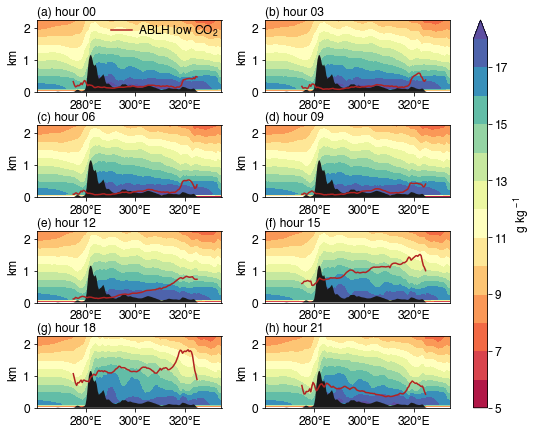

In [33]:
fontsize=12

#nrows=4;ncols=2
#fig,axes = mp.subplots(nrows=nrows,ncols=ncols,subplot_kw={'projection': cartopy.crs.PlateCarree()})
#fig.set_size_inches(3.25,4)

fig = mp.figure(figsize=(6.5,6))

y_zero = numpy.zeros(xlong.shape[1])
levels = numpy.arange(5,19,1)

xticks_deg_E=numpy.array((280,300,320))
xticks = -(360-xticks_deg_E)
xticks_format=[str(tick)+DEGREE_SIGN+'E' for tick in xticks_deg_E]

nrows=4;ncols=2
ax_list = []

for t in range(8):
    ax = fig.add_subplot(nrows,ncols,t+1)#, projection=cartopy.crs.PlateCarree())
    
    contour_plot = ax.contourf(xlong[0,:]+360.,z,qvapor_400_array[t]*1000.,\
                               levels=levels,\
                               cmap='Spectral',extend='max')
    ax.plot(xlong[0,:]+360.,pblh_400_array[t]/1000.,c='firebrick', label='ABLH low CO$_2$')
    #ax.plot(xlong[0,:]+360.,pblh_1000_array[t]/1000.,c='firebrick',ls='--', label='ABLH high CO$_2$')
    
    ax.tick_params(labelsize=fontsize)
    ax.set_ylim(0,2.25)
    ax.set_xlim(xlong.min()+55.+360.,xlong.max()+360.)
    
    ax.fill_between(xlong[0,:]+360., y_zero, HGT_M_lat_subset_mean/1000., facecolor='0.1', interpolate=True)
    
    ax.set_yticks([0,1,2])
    ax.set_xticks([280,300,320])
    ax.set_xticklabels(xticks_format)
    ax.set_ylabel('km', fontsize=fontsize)
    
    ax.text(s='('+string.ascii_lowercase[t]+') hour '+hour_strings[t], x=0, y=1.02,\
            transform=ax.transAxes,fontsize=fontsize,ha='left',va='bottom')
    
    ax_list.append(ax)

fig.tight_layout()

top_pos = ax_list[1].get_position()
bottom_pos = ax_list[7].get_position()
cbar_axes = fig.add_axes([bottom_pos.x1+0.05, bottom_pos.y0, 0.03, top_pos.y1-bottom_pos.y0])
cbar = mp.colorbar(contour_plot, orientation='vertical', cax=cbar_axes)
cbar_axes.tick_params(labelsize=fontsize)
#cbar_axes.text(s='g kg$^{\,-1}$', x=0.5, y=1.00666, transform=cbar_axes.transAxes, fontsize=fontsize, ha='center', va='bottom')
cbar.set_label('g kg$^{\,-1}$', fontsize=fontsize)
#cbar.set_ticks(numpy.arange(-0.8,0.81,0.2))

handles, labels = ax_list[0].get_legend_handles_labels()
legend = ax_list[0].legend(handles, labels, fontsize=fontsize, ncol=1, bbox_to_anchor=(1,1), \
                   edgecolor='None', facecolor='None', fancybox=False, bbox_transform=ax_list[0].transAxes, \
                   loc='upper right', labelspacing=0, \
                   borderaxespad=0, borderpad=0.25, handlelength=1.75, \
                   handletextpad=0.5)

fig.savefig('figure6.5_qvapor_400_cross_sections_zoom.png', dpi=600, bbox_inches='tight', transparent=True)

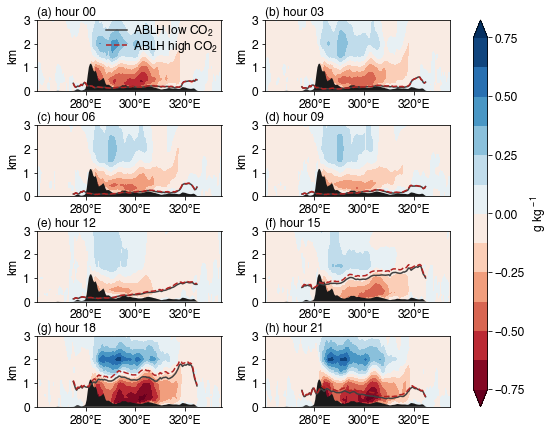

In [34]:
fontsize=12

fig = mp.figure(figsize=(6.5,6))

y_zero = numpy.zeros(xlong.shape[1])
levels = numpy.arange(-0.75,0.76,0.125)

xticks_deg_E=numpy.array((280,300,320))
xticks = -(360-xticks_deg_E)
xticks_format=[str(tick)+DEGREE_SIGN+'E' for tick in xticks_deg_E]

nrows=4;ncols=2
ax_list = []

for t in range(8):
    ax = fig.add_subplot(nrows,ncols,t+1)#, projection=cartopy.crs.PlateCarree())
    
    contour_plot = ax.contourf(xlong[0,:]+360.,z,qvapor_diffs_array[t]*1000.,levels=levels,cmap='RdBu',extend='both')
    ax.plot(xlong[0,:]+360.,pblh_400_array[t]/1000.,c='0.25', label='ABLH low CO$_2$')
    ax.plot(xlong[0,:]+360.,pblh_1000_array[t]/1000.,c='firebrick',ls='--', label='ABLH high CO$_2$')
    
    ax.tick_params(labelsize=fontsize)
    ax.set_ylim(0,3)
    ax.set_xlim(xlong.min()+55.+360.,xlong.max()+360.)
    
    ax.fill_between(xlong[0,:]+360., y_zero, HGT_M_lat_subset_mean/1000., facecolor='0.1', interpolate=True)
    
    ax.set_yticks([0,1,2,3])
    ax.set_xticks([280,300,320])
    ax.set_xticklabels(xticks_format)
    ax.set_ylabel('km', fontsize=fontsize)
    
    ax.text(s='('+string.ascii_lowercase[t]+') hour '+hour_strings[t], x=0, y=1.02,\
            transform=ax.transAxes,fontsize=fontsize,ha='left',va='bottom')
    
    ax_list.append(ax)

fig.tight_layout()

top_pos = ax_list[1].get_position()
bottom_pos = ax_list[7].get_position()
cbar_axes = fig.add_axes([bottom_pos.x1+0.05, bottom_pos.y0, 0.03, top_pos.y1-bottom_pos.y0])
cbar = mp.colorbar(contour_plot, orientation='vertical', cax=cbar_axes)
cbar_axes.tick_params(labelsize=fontsize)
#cbar_axes.text(s='g kg$^{\,-1}$', x=0.5, y=1.00666, transform=cbar_axes.transAxes, fontsize=fontsize, ha='center', va='bottom')
cbar.set_label('g kg$^{\,-1}$', fontsize=fontsize)
#cbar.set_ticks(numpy.arange(-0.8,0.81,0.2))

handles, labels = ax_list[0].get_legend_handles_labels()
legend = ax_list[0].legend(handles, labels, fontsize=fontsize, ncol=1, bbox_to_anchor=(1,1), \
                   edgecolor='None', facecolor='None', fancybox=False, bbox_transform=ax_list[0].transAxes, \
                   loc='upper right', labelspacing=0, \
                   borderaxespad=0, borderpad=0.25, handlelength=1.75, \
                   handletextpad=0.5)

fig.savefig('figure6_qvapor_pblh_cross_sections.png', dpi=600, bbox_inches='tight', transparent=True)

# figure 6

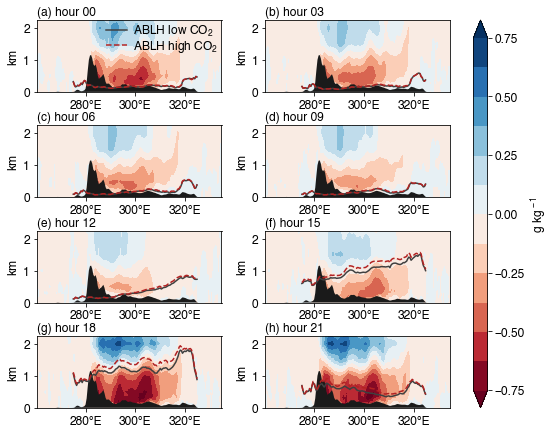

In [35]:
fontsize=12

#nrows=4;ncols=2
#fig,axes = mp.subplots(nrows=nrows,ncols=ncols,subplot_kw={'projection': cartopy.crs.PlateCarree()})
#fig.set_size_inches(3.25,4)

fig = mp.figure(figsize=(6.5,6))

y_zero = numpy.zeros(xlong.shape[1])
levels = numpy.arange(-0.75,0.76,0.125)

xticks_deg_E=numpy.array((280,300,320))
xticks = -(360-xticks_deg_E)
xticks_format=[str(tick)+DEGREE_SIGN+'E' for tick in xticks_deg_E]

nrows=4;ncols=2
ax_list = []

for t in range(8):
    ax = fig.add_subplot(nrows,ncols,t+1)#, projection=cartopy.crs.PlateCarree())
    
    contour_plot = ax.contourf(xlong[0,:]+360.,z,qvapor_diffs_array[t]*1000.,levels=levels,cmap='RdBu',extend='both')
    ax.plot(xlong[0,:]+360.,pblh_400_array[t]/1000.,c='0.25', label='ABLH low CO$_2$')
    ax.plot(xlong[0,:]+360.,pblh_1000_array[t]/1000.,c='firebrick',ls='--', label='ABLH high CO$_2$')
    
    ax.tick_params(labelsize=fontsize)
    ax.set_ylim(0,2.25)
    ax.set_xlim(xlong.min()+55.+360.,xlong.max()+360.)
    
    ax.fill_between(xlong[0,:]+360., y_zero, HGT_M_lat_subset_mean/1000., facecolor='0.1', interpolate=True)
    
    ax.set_yticks([0,1,2])
    ax.set_xticks([280,300,320])
    ax.set_xticklabels(xticks_format)
    ax.set_ylabel('km', fontsize=fontsize)
    
    ax.text(s='('+string.ascii_lowercase[t]+') hour '+hour_strings[t], x=0, y=1.02,\
            transform=ax.transAxes,fontsize=fontsize,ha='left',va='bottom')
    
    ax_list.append(ax)

fig.tight_layout()

top_pos = ax_list[1].get_position()
bottom_pos = ax_list[7].get_position()
cbar_axes = fig.add_axes([bottom_pos.x1+0.05, bottom_pos.y0, 0.03, top_pos.y1-bottom_pos.y0])
cbar = mp.colorbar(contour_plot, orientation='vertical', cax=cbar_axes)
cbar_axes.tick_params(labelsize=fontsize)
#cbar_axes.text(s='g kg$^{\,-1}$', x=0.5, y=1.00666, transform=cbar_axes.transAxes, fontsize=fontsize, ha='center', va='bottom')
cbar.set_label('g kg$^{\,-1}$', fontsize=fontsize)
#cbar.set_ticks(numpy.arange(-0.8,0.81,0.2))

handles, labels = ax_list[0].get_legend_handles_labels()
legend = ax_list[0].legend(handles, labels, fontsize=fontsize, ncol=1, bbox_to_anchor=(1,1), \
                   edgecolor='None', facecolor='None', fancybox=False, bbox_transform=ax_list[0].transAxes, \
                   loc='upper right', labelspacing=0, \
                   borderaxespad=0, borderpad=0.25, handlelength=1.75, \
                   handletextpad=0.5)

fig.savefig('figure6_qvapor_pblh_cross_sections_zoom.png', dpi=600, bbox_inches='tight', transparent=True)

# create FIGURE 7 maps of PBLH change

In [36]:
import matplotlib.colors

class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y))

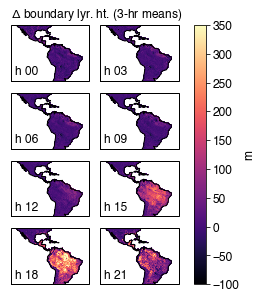

In [37]:
fontsize=12

#nrows=4;ncols=2
#fig,axes = mp.subplots(nrows=nrows,ncols=ncols,subplot_kw={'projection': cartopy.crs.PlateCarree()})
#fig.set_size_inches(3.25,4)

fig = mp.figure(figsize=(3.25,4))

y_zero = numpy.zeros(xlong.shape[1])
#levels = numpy.arange(-100,101,20)
levels = numpy.hstack((numpy.arange(-15,0,5), numpy.arange(0,250,25)))

xticks_deg_E=numpy.array((250,300,325))
xticks = -(360-xticks_deg_E)
xticks_format=[str(tick)+DEGREE_SIGN+'E' for tick in xticks_deg_E]

nrows=4;ncols=2
ax_list = []

for t in range(8):
    ax = fig.add_subplot(nrows,ncols,t+1, projection=cartopy.crs.PlateCarree())
    ax.set_extent([xlong.min()+25., xlong.max(), xlat.min(), xlat.max()], crs=cartopy.crs.PlateCarree())
    ax.coastlines(resolution='110m')
    
    #contour_plot = ax.contourf(xlong[0,:],xlat[:,0],pblh_diffs_2d_array[t],levels=levels,cmap='Spectral_r',extend='max',\
    #                          norm=MidpointNormalize(midpoint=0.0))
    contour_plot = ax.pcolormesh(xlong[0,:],xlat[:,0],pblh_diffs_2d_array[t,:,:],cmap='magma',vmin=-100,vmax=350)
                                #,vmin=-25,vmax=250,cmap='Spectral_r',\
                                 #norm=MidpointNormalize(midpoint=0.0))
    #ax.contour(xlong[0,:],xlat[:,0],pblh_diffs_2d_array[t],levels=[0])
    
    ax.tick_params(labelsize=fontsize)
    
    #ax.text(s='hour '+hour_strings[t], x=0, y=1.02,\
    #        transform=ax.transAxes,fontsize=fontsize,ha='left',va='bottom')
    
    ax.text(s='h '+hour_strings[t], x=0.05, y=0.05, transform=ax.transAxes, ha='left', va='bottom', fontsize=fontsize)
    ax_list.append(ax)

# ('+string.ascii_lowercase[t]+') 
fig.tight_layout(w_pad=-2.5, h_pad=0.5)

top_pos = ax_list[1].get_position()
bottom_pos = ax_list[7].get_position()
cbar_axes = fig.add_axes([bottom_pos.x1-0.03, bottom_pos.y0, 0.05, top_pos.y1-bottom_pos.y0])
cbar = mp.colorbar(contour_plot, orientation='vertical', cax=cbar_axes)
cbar_axes.tick_params(labelsize=fontsize)
cbar.set_label('m', fontsize=fontsize)
#cbar.set_ticks(numpy.arange(-50,451,50))

ax_list[0].text(s='$\Delta$ boundary lyr. ht. (3-hr means)', x=0, y=1.04, transform=ax_list[0].transAxes, fontsize=fontsize, ha='left', va='bottom')

# yticks = [-30,0,30]
# yticks_format = ['30'+DEGREE_SIGN+'S', '0', '30'+DEGREE_SIGN+'N']
# ax_list[0].set_yticks(yticks)
# ax_list[2].set_yticks(yticks)
# ax_list[4].set_yticks(yticks)
# ax_list[6].set_yticks(yticks)
# ax_list[0].set_yticklabels(yticks_format)
# ax_list[2].set_yticklabels(yticks_format)
# ax_list[4].set_yticklabels(yticks_format)
# ax_list[6].set_yticklabels(yticks_format)

# xticks = [-]
# ax_list[6].set_xticks()

fig.savefig('figure7_PBLH_change_map.png', dpi=600, bbox_inches='tight', transparent=True)

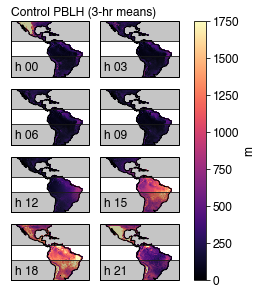

In [53]:
fontsize=12

#nrows=4;ncols=2
#fig,axes = mp.subplots(nrows=nrows,ncols=ncols,subplot_kw={'projection': cartopy.crs.PlateCarree()})
#fig.set_size_inches(3.25,4)

fig = mp.figure(figsize=(3.25,4))

y_zero = numpy.zeros(xlong.shape[1])
#levels = numpy.arange(-100,101,20)
levels = numpy.hstack((numpy.arange(-15,0,5), numpy.arange(0,250,25)))

xticks_deg_E=numpy.array((250,300,325))
xticks = -(360-xticks_deg_E)
xticks_format=[str(tick)+DEGREE_SIGN+'E' for tick in xticks_deg_E]

nrows=4;ncols=2
ax_list = []

for t in range(8):
    ax = fig.add_subplot(nrows,ncols,t+1, projection=cartopy.crs.PlateCarree())
    ax.set_extent([xlong.min()+25., xlong.max(), xlat.min(), xlat.max()], crs=cartopy.crs.PlateCarree())
    ax.coastlines(resolution='110m')
    
    ax.axhspan(-90,-10,alpha=0.25,color='0.1')
    ax.axhspan(10,90,alpha=0.25,color='0.1')
    
    gridlines_plot = ax.gridlines(ylocs=[-10,10], color='0.1')
    gridlines_plot.xlines = False
    
    contour_plot = ax.pcolormesh(xlong[0,:],xlat[:,0],pblh_400_2d_array[t,:,:],\
                                 cmap='magma',\
                                 vmin=0, \
                                 vmax=1750)#,\
                                 #vmin=0,\
                                 #vmax=)

    #ax.contour(xlong[0,:],xlat[:,0],pblh_diffs_2d_array[t],levels=[0])
    
    ax.tick_params(labelsize=fontsize)
    
    #ax.text(s='hour '+hour_strings[t], x=0, y=1.02,\
    #        transform=ax.transAxes,fontsize=fontsize,ha='left',va='bottom')
    
    ax.text(s='h '+hour_strings[t], x=0.05, y=0.05, transform=ax.transAxes, ha='left', va='bottom', fontsize=fontsize)
    ax_list.append(ax)

# ('+string.ascii_lowercase[t]+') 
fig.tight_layout(w_pad=-2.5, h_pad=0.5)

top_pos = ax_list[1].get_position()
bottom_pos = ax_list[7].get_position()
cbar_axes = fig.add_axes([bottom_pos.x1-0.03, bottom_pos.y0, 0.05, top_pos.y1-bottom_pos.y0])
cbar = mp.colorbar(contour_plot, orientation='vertical', cax=cbar_axes)
cbar_axes.tick_params(labelsize=fontsize)
cbar.set_label('m', fontsize=fontsize)
cbar.set_ticks(numpy.arange(0,1751,250))

ax_list[0].text(s='Control PBLH (3-hr means)', x=0, y=1.04, transform=ax_list[0].transAxes, fontsize=fontsize, ha='left', va='bottom')

fig.savefig('figure7.5_PBLH_climatology_map.png', dpi=600, bbox_inches='tight', transparent=True)